In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default")

In [57]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

In [58]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [59]:
cols_zscore = data.keys().drop("quality")

In [60]:
data = data[data["total sulfur dioxide"]<200]
data[cols_zscore] = data[cols_zscore].apply(stats.zscore)
data['bool_quality'] = 0
data["bool_quality"][data['quality']>5] = 1

<ipython-input-60-63ab8adbd3dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["bool_quality"][data['quality']>5] = 1


In [61]:
X = torch.tensor(data[cols_zscore].values).float()
y = torch.tensor(data["bool_quality"].values).float()

y = y.reshape(-1,1)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [63]:
train_dataset.tensors[0]

tensor([[-0.6432,  0.9327, -0.7228,  ..., -0.1395, -0.6982, -0.3014],
        [-0.8154, -0.7159, -0.1568,  ..., -0.3342, -0.4622, -0.3954],
        [-1.3896,  0.1224, -0.8772,  ...,  1.3534,  0.5999,  0.7325],
        ...,
        [ 0.2755,  0.1224, -1.1860,  ..., -0.6587, -0.3442,  0.4506],
        [-0.7006,  1.2680, -0.6199,  ..., -0.7886, -0.9342, -0.8653],
        [-1.1025,  0.0106, -0.9287,  ...,  1.2236,  0.0688,  0.5446]])

In [64]:
X_train.shape

torch.Size([1197, 11])

In [77]:
class Model(nn.Module):

  def __init__(self):

    super().__init__()

    self.inp = nn.Linear(train_dataset.tensors[0].shape[1], 16)

    self.hid1 = nn.Linear(16, 32)
    self.bnorm1 = nn.BatchNorm1d(16) #batch norm para la primera capa oculta

    self.hid2 = nn.Linear(32, 16)
    self.bnorm2 = nn.BatchNorm1d(32) #batch norm para la segunda capa oculta

    self.out = nn.Linear(16, train_dataset.tensors[1].shape[1])


  def forward(self, x, bnorm):
    #el parámetro booleano bnorm indica si se aplica o no batch norm (si esta entrenándose)

    x = F.relu(self.inp(x)) #los valores que toma la capa de entrada ya están normalizados

    if bnorm:

      x = self.bnorm1(x) #batch norm
      x = F.relu(self.hid1(x))

      x = self.bnorm2(x)
      x = F.relu(self.hid2(x))

    else:
      #aplicamos una propagación adelante corriente
      x = F.relu(self.hid1(x))
      x = F.relu(self.hid2(x))

    return self.out(x)





In [78]:
n_epochs = 1000

In [89]:
from tqdm import tqdm

In [90]:
def train_model(model, do_bnorm=True):

  loss_func = nn.BCEWithLogitsLoss()
  optim = torch.optim.SGD(model.parameters(), lr=0.01)

  losses = torch.zeros(n_epochs)
  train_accs = []
  test_accs = []

  for epoch in tqdm(range(n_epochs)):

      model.train()

      for (X_batch, y_batch) in train_loader:

          model.train()

          batch_train_accs = []
          batch_losses = []

          y_hat = model(X_batch, bnorm=do_bnorm) #forward pass

          loss = loss_func(y_hat, y_batch) #compute error

          optim.zero_grad() #clear gradient cache
          loss.backward()
          optim.step() #update parameters


          #store accuracies & losses
          batch_train_accs.append(100*torch.mean(((y_hat>0) == y_batch).float()).item())
          batch_losses.append(loss.item())

      train_accs.append(np.mean(batch_train_accs))
      losses[epoch] = np.mean(batch_losses)

      model.eval()
      X_test, y_test = next(iter(test_loader))

      with torch.no_grad():
          y_pred = model(X_test, do_bnorm)

      test_accs.append(100*torch.mean(((y_pred>0) == y_test).float()).item())


  return losses, train_accs, test_accs






In [91]:
Model()

Model(
  (inp): Linear(in_features=11, out_features=16, bias=True)
  (hid1): Linear(in_features=16, out_features=32, bias=True)
  (bnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hid2): Linear(in_features=32, out_features=16, bias=True)
  (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [92]:
Model()(X_train, True)

tensor([[-0.1616],
        [-0.1565],
        [ 0.2096],
        ...,
        [-0.0159],
        [-0.0549],
        [-0.0944]], grad_fn=<AddmmBackward0>)

In [93]:
model_bnorm = Model()
losses1, train_accs1, test_accs1 = train_model(model_bnorm, do_bnorm=True)


model_no_bnorm = Model()
losses2, train_accs2, test_accs2 = train_model(model_no_bnorm, do_bnorm=False)

100%|██████████| 1000/1000 [01:00<00:00, 16.44it/s]


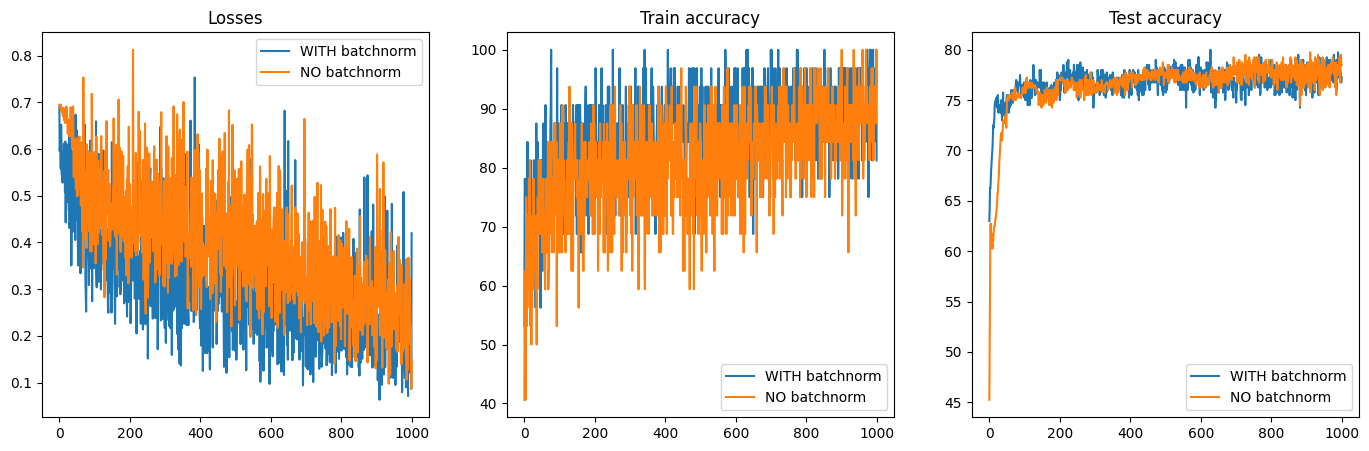

In [97]:
fig,axs = plt.subplots(1,3,figsize=(17,5))

axs[0].plot(losses1,label='WITH batchnorm')
axs[0].plot(losses2,label='NO batchnorm')
axs[0].set_title('Losses')
axs[0].legend()

axs[1].plot(train_accs1,label='WITH batchnorm')
axs[1].plot(train_accs2,label='NO batchnorm')
axs[1].set_title('Train accuracy')
axs[1].legend()

axs[2].plot(test_accs1,label='WITH batchnorm')
axs[2].plot(test_acc2s,label='NO batchnorm')
axs[2].set_title('Test accuracy')
axs[2].legend()

plt.show()